# 1.6e: Axial Tomography (Density Heatmaps)

This notebook creates density heatmaps of axial slices to reveal structure more clearly than scatter plots.

## The Question

In 1.6d, we saw striking asymmetry in the equatorial slices:
- **Slices 8-13 (above equator):** Roughly spherical, uniform distribution
- **Slices 6-7 (equatorial):** Concentrated beam/jet pointing toward -135° to -180°
- **Slices 1-5 (below equator):** Nearly empty void

**Density heatmaps** will make this structure even clearer by:
- Aggregating tokens into bins (no overlapping points)
- Showing continuous density field
- Making subtle gradients and features more visible

## Method

We'll:
1. Slice the universe perpendicular to north axis (same as 1.6d)
2. For each slice, bin tokens into 2D histogram (r, θ)
3. Display as polar heatmap with 'hot' colormap
4. 4×4 grid from south pole → north pole

## Parameters

In [54]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis selection
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Tomography parameters
NUM_SLICES = 16  # Total number of slices

# Binning parameters
NUM_THETA_BINS = 180  # Angular bins (1° resolution)
NUM_R_BINS = 500      # Radial bins

# Visualization
COLORMAP = 'inferno'  # Dark background, hot = dense
FIGSIZE = (20, 20)
DPI = 200

## Imports

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [56]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [57]:
# Load W
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")

Loaded W: torch.Size([151936, 2560])


In [58]:
# Load cluster-centric reference frame
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid: {cluster_centroid.shape}")
print(f"  PCA eigenvectors: {eigenvectors.shape}")


Loaded reference frame:
  Cluster centroid: torch.Size([2560])
  PCA eigenvectors: torch.Size([2560, 2560])


## Define Basis Vectors

In [59]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"\nBasis defined:")
print(f"  North (z-axis): PC{NORTH_PC}")
print(f"  Meridian (x-axis): PC{MERIDIAN_PC}")
print(f"  Equinox (y-axis): PC{EQUINOX_PC}")


Basis defined:
  North (z-axis): PC2
  Meridian (x-axis): PC1
  Equinox (y-axis): PC3


## Compute Cartesian Coordinates

In [60]:
print("\nComputing Cartesian coordinates (x, y, z) in PCA basis...\n")

# Translate to cluster-centric frame
W_centered = W - cluster_centroid

# Project onto basis vectors
x = W_centered @ meridian
y = W_centered @ equinox
z = W_centered @ north

print(f"✓ Cartesian coordinates computed")
print(f"\nCoordinate ranges:")
print(f"  x (meridian): [{x.min().item():.6f}, {x.max().item():.6f}]")
print(f"  y (equinox):  [{y.min().item():.6f}, {y.max().item():.6f}]")
print(f"  z (north):    [{z.min().item():.6f}, {z.max().item():.6f}]")


Computing Cartesian coordinates (x, y, z) in PCA basis...

✓ Cartesian coordinates computed

Coordinate ranges:
  x (meridian): [-1.112826, 0.417888]
  y (equinox):  [-0.248493, 0.136058]
  z (north):    [-0.177021, 0.314756]


## Define Slices

In [61]:
print(f"\nDefining {NUM_SLICES} axial slices...\n")

# Convert to numpy
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()
z_np = z.cpu().numpy()

# Define slice boundaries
z_min = z_np.min()
z_max = z_np.max()
z_edges = np.linspace(z_min, z_max, NUM_SLICES + 1)

print(f"✓ Slice boundaries defined")
print(f"  z range: [{z_min:.6f}, {z_max:.6f}]")
print(f"  Slice thickness: {(z_max - z_min) / NUM_SLICES:.6f}")


Defining 16 axial slices...

✓ Slice boundaries defined
  z range: [-0.177021, 0.314756]
  Slice thickness: 0.030736


## Compute Maximum Radius for Binning

In [62]:
# Compute radial distance in (x, y) plane
r_xy = np.sqrt(x_np**2 + y_np**2)
r_max = r_xy.max()

print(f"\nRadial distance range: [0, {r_max:.6f}]")


Radial distance range: [0, 1.112836]


## Create Tomography Grid with Density Heatmaps


Creating axial tomography density heatmaps...



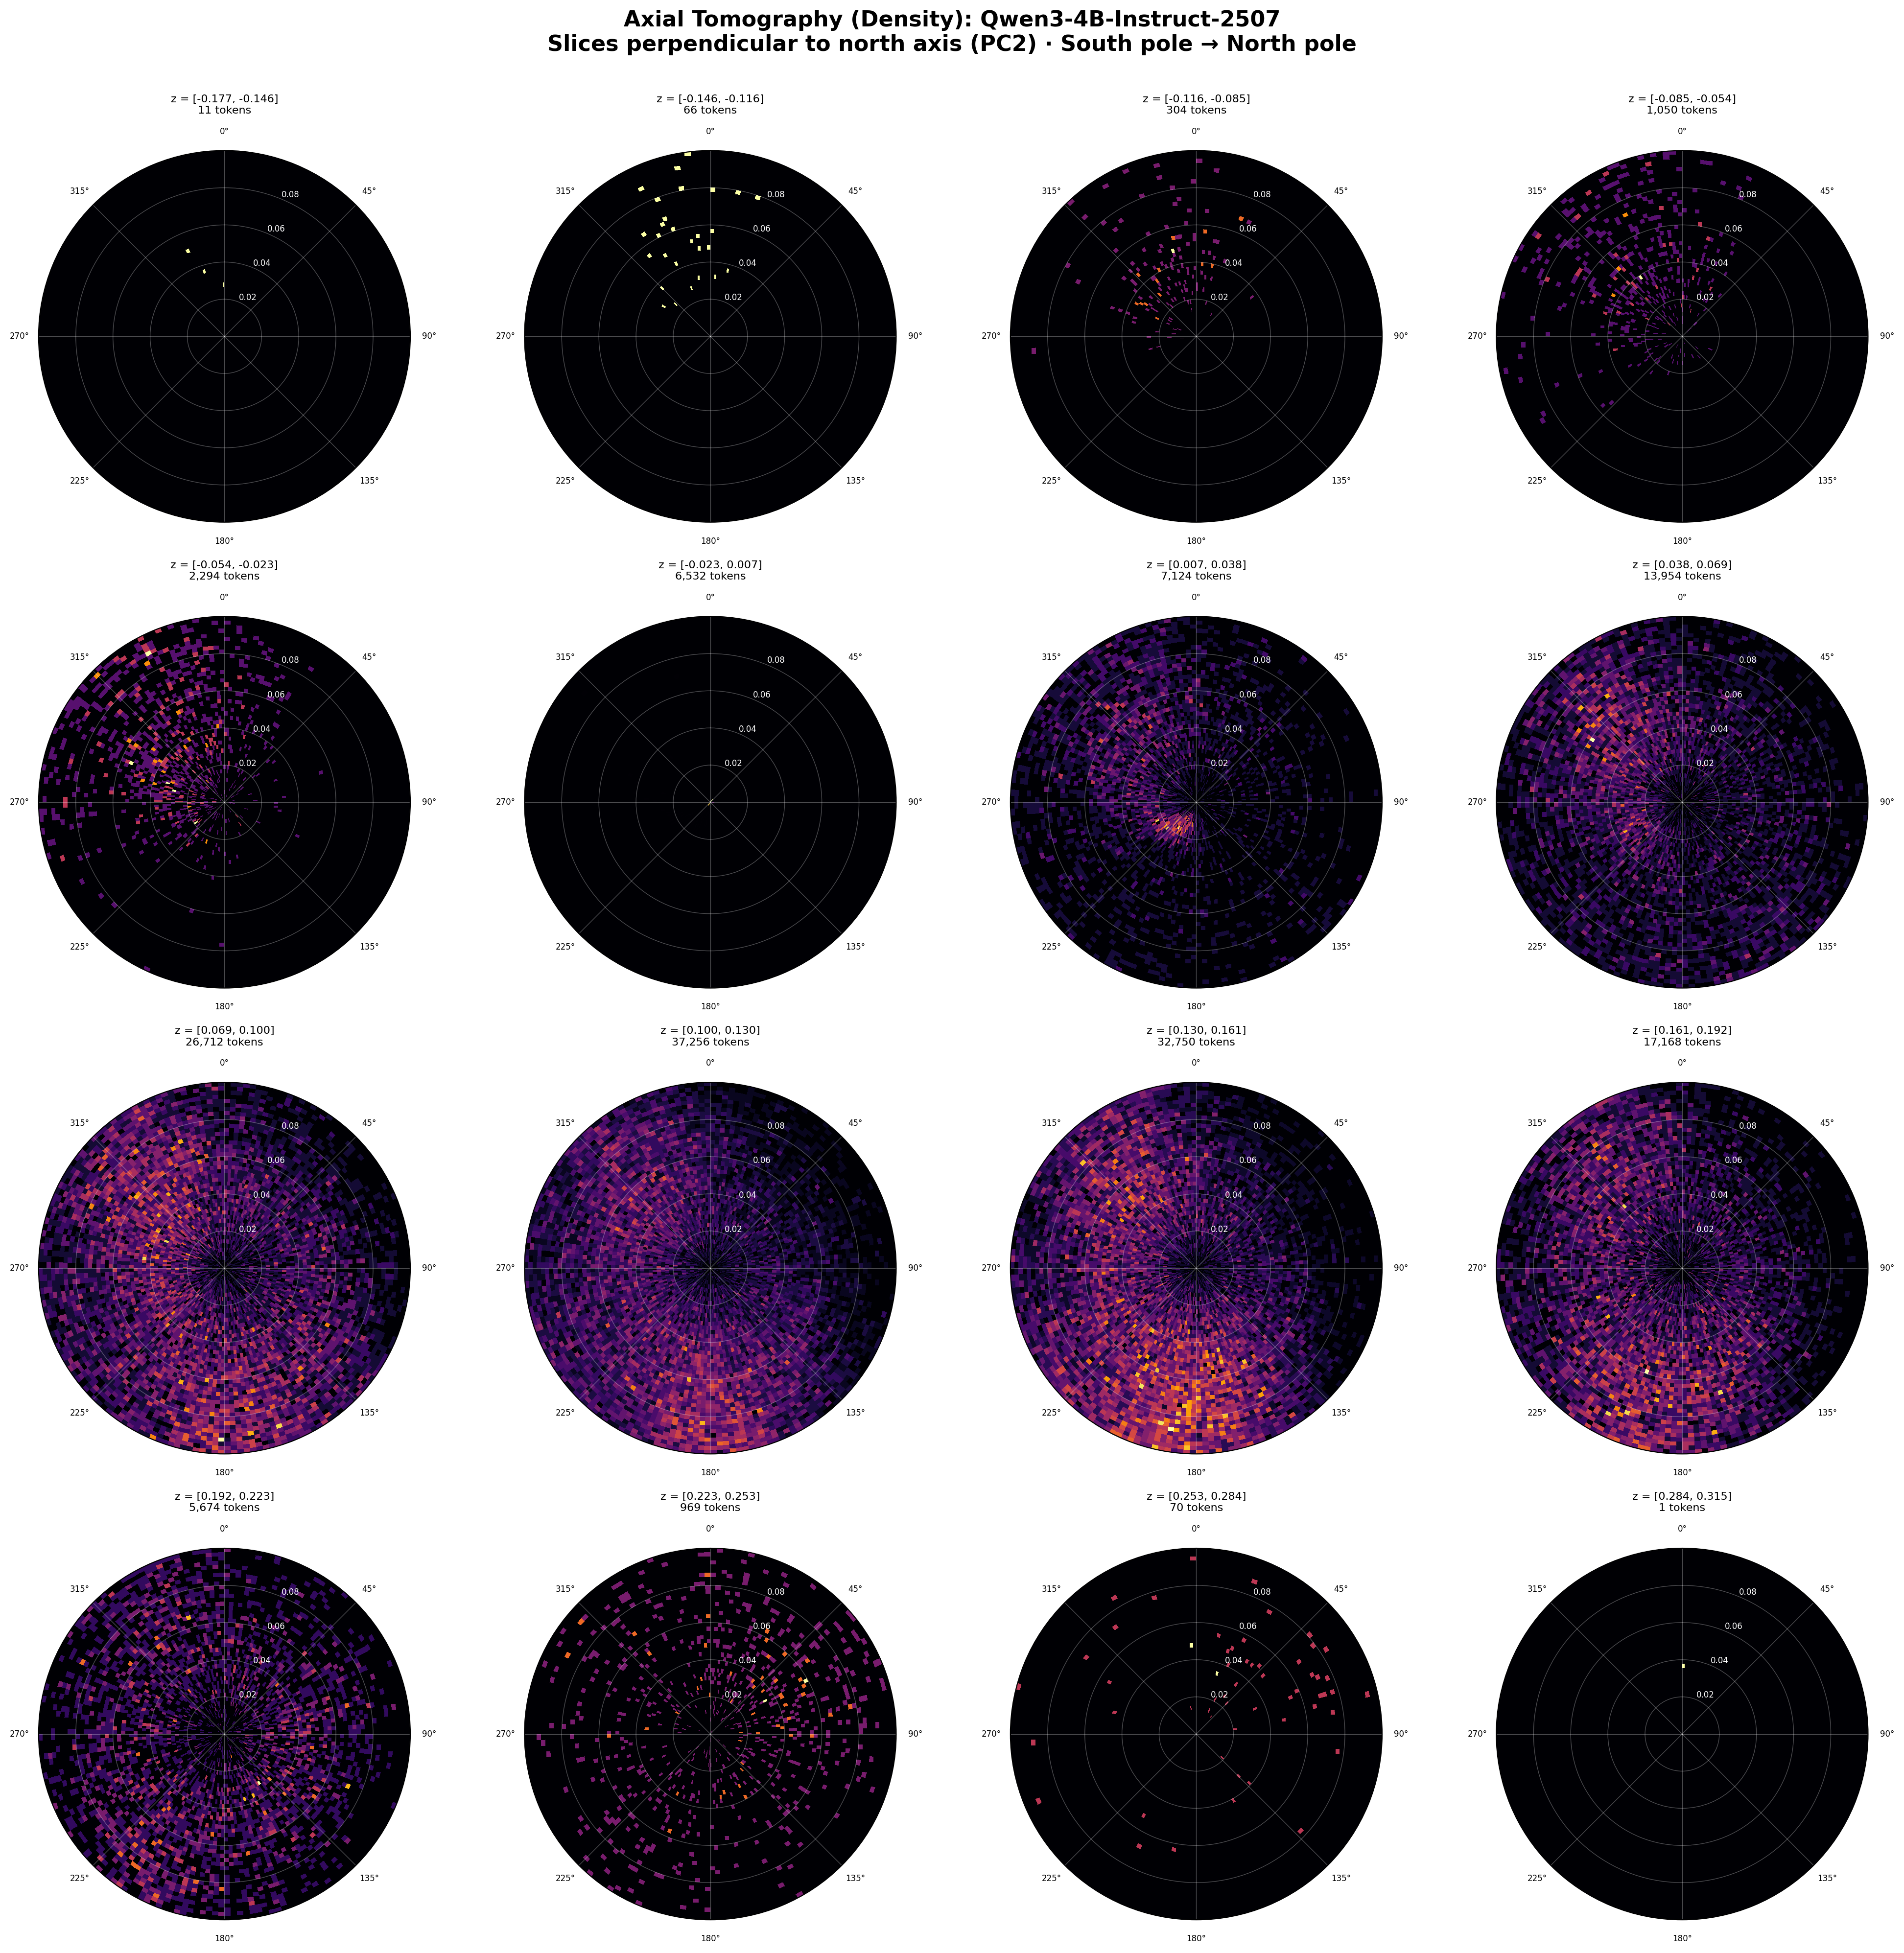

✓ Tomography density heatmaps complete


In [63]:
print(f"\nCreating axial tomography density heatmaps...\n")

# Create 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=FIGSIZE, dpi=DPI, 
                         subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Define bins
theta_bins = np.linspace(-np.pi, np.pi, NUM_THETA_BINS + 1)
r_bins = np.linspace(0, r_max, NUM_R_BINS + 1)

# Process each slice
for i in range(NUM_SLICES):
    # Get slice boundaries
    z_low = z_edges[i]
    z_high = z_edges[i + 1]
    z_mid = (z_low + z_high) / 2
    
    # Filter tokens in this slice
    mask = (z_np >= z_low) & (z_np < z_high)
    x_slice = x_np[mask]
    y_slice = y_np[mask]
    
    # Convert to polar coordinates in (x, y) plane
    r_slice = np.sqrt(x_slice**2 + y_slice**2)
    theta_slice = np.arctan2(y_slice, x_slice)
    
    # Create 2D histogram
    H, theta_edges, r_edges = np.histogram2d(theta_slice, r_slice, 
                                              bins=[theta_bins, r_bins])
    
    # Meshgrid for pcolormesh
    Theta, R = np.meshgrid(theta_edges, r_edges)
    
    # Plot heatmap on polar axes
    ax = axes[i]
    mesh = ax.pcolormesh(Theta, R, H.T, cmap=COLORMAP, shading='auto', rasterized=True)
    
    # Formatting
    ax.set_facecolor('black')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
    
    # Title with z-range and token count
    ax.set_title(f'z = [{z_low:.3f}, {z_high:.3f}]\n{mask.sum():,} tokens',
                 fontsize=8, color='black', pad=10)
    
    # Convert tick positions from radians to degrees for labeling
    # Get default tick locations
    tick_locs = ax.get_xticks()
    # Convert to degrees
    tick_degs = np.rad2deg(tick_locs)
    # Wrap to -180 to 180 range
    tick_degs = ((tick_degs + 180) % 360) - 180
    # Set labels
    # ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])
    
    # Tick formatting
    ax.tick_params(labelsize=6)
    for label in ax.get_xticklabels():
        label.set_color('black')
    for label in ax.get_yticklabels():
        label.set_color('white')

    ax.set_rlim(bottom=0.0, top=0.1)

# Overall title
fig.suptitle(f'Axial Tomography (Density): {MODEL_NAME}\n' + 
             f'Slices perpendicular to north axis (PC{NORTH_PC}) · South pole → North pole',
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print("✓ Tomography density heatmaps complete")

## Observations

The density heatmaps should make structure much clearer than scatter plots:

**Look for:**

**Equatorial jet/beam (slices 6-7):**
- Hot spot pointing toward -135° to -180°?
- Is it concentrated at specific radius?
- How sharp is the boundary?

**Vertical asymmetry:**
- Dense in northern hemisphere (slices 8-13)?
- Void in southern hemisphere (slices 1-5)?
- Where's the transition?

**Radial structure:**
- Does density peak at center (near z-axis)?
- Or at specific radius (shell/ring)?
- Does this change with latitude?

**Angular structure:**
- Is the jet confined to narrow angle?
- Or broad feature?
- Does it rotate/shift with latitude?

The 'hot' colormap (black = empty, red = warm, yellow/white = hot) should make the jet structure immediately obvious if it's real.